In [1]:
!pip install SciencePlots --upgrade
!sudo apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 57.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd

import os, json # cv2 -- OpenCV
import shutil
import zipfile

import scienceplots

plt.style.use(['science','nature'])

%matplotlib inline

In [3]:
res_folder = '/content/drive/MyDrive/Research/Quanvolution/notebooks/eqx'
res_files = [file for file in os.listdir(res_folder) if file.endswith('.json')]
print(res_files)

['20240429_115118_MNIST_replacement_lvl_2_rep_0.json', '20240429_115120_FashionMNIST_replacement_lvl_2_rep_0.json', '20240429_115118_MNIST_replacement_lvl_2_rep_1.json', '20240429_115120_FashionMNIST_replacement_lvl_2_rep_1.json', '20240429_115118_MNIST_replacement_lvl_2_rep_2.json', '20240429_115120_FashionMNIST_replacement_lvl_2_rep_2.json', '20240429_115118_MNIST_replacement_lvl_2_rep_3.json', '20240429_200703_FashionMNIST_replacement_lvl_2_rep_3.json', '20240429_115118_MNIST_replacement_lvl_2_rep_4.json', '20240429_200703_FashionMNIST_replacement_lvl_2_rep_4.json', '20240429_115118_MNIST_replacement_lvl_1_rep_0.json', '20240429_200703_FashionMNIST_replacement_lvl_1_rep_0.json', '20240429_115118_MNIST_replacement_lvl_1_rep_1.json', '20240430_020111_CIFAR10_replacement_lvl_1_rep_0.json', '20240429_200703_FashionMNIST_replacement_lvl_1_rep_1.json', '20240429_115118_MNIST_replacement_lvl_1_rep_2.json', '20240430_020111_CIFAR10_replacement_lvl_1_rep_1.json', '20240429_200703_FashionMNIS

In [5]:
reps = [0,1,2,3,4]
replacement_lvls = [0,1,2]
datasets = ['MNIST', 'FashionMNIST', 'CIFAR10']
metrics = ['train_loss', 'train_acc', 'test_loss', 'test_acc']

def calculate_mean_std(dataset_name:str, replacement_lvl:int, res_folder:str):
  res_files_all = [file for file in os.listdir(res_folder) if file.endswith('.json')]
  res_files = [file for file in res_files_all if f"_{dataset_name}_" in file and f"replacement_lvl_{replacement_lvl}" in file]
  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for file in res_files:
    with open(os.path.join(res_folder, file), 'r') as f:
      data = json.load(f)
    train_losses.append(data['train_loss'])
    train_accs.append(data['train_acc'])
    test_losses.append(data['test_loss'])
    test_accs.append(data['test_acc'])
  train_losses = np.array(train_losses)
  train_accs = np.array(train_accs)
  test_losses = np.array(test_losses)
  test_accs = np.array(test_accs)
  train_loss_avg = np.mean(train_losses, axis=0)
  train_acc_avg = np.mean(train_accs, axis=0)
  test_loss_avg = np.mean(test_losses, axis=0)
  test_acc_avg = np.mean(test_accs, axis=0)
  train_loss_std = np.std(train_losses, axis=0)
  train_acc_std = np.std(train_accs, axis=0)
  test_loss_std = np.std(test_losses, axis=0)
  test_acc_std = np.std(test_accs, axis=0)
  metrics_avg = {
      'train_loss': train_loss_avg,
      'train_acc': train_acc_avg,
      'test_loss': test_loss_avg,
      'test_acc': test_acc_avg
  }
  metrics_std = {
      'train_loss': train_loss_std,
      'train_acc': train_acc_std,
      'test_loss': test_loss_std,
      'test_acc': test_acc_std
  }
  return metrics_avg, metrics_std

processed_avg = {}
processed_std = {}

last_iter_avg = {}
last_iter_std = {}

first_iter_avg = {}
first_iter_std = {}

for dataset in datasets:
  processed_avg[dataset] = {}
  processed_std[dataset] = {}
  last_iter_avg[dataset] = {}
  last_iter_std[dataset] = {}
  first_iter_avg[dataset] = {}
  first_iter_std[dataset] = {}
  for replacement_lvl in replacement_lvls:
    metrics_avg, metrics_std = calculate_mean_std(dataset, replacement_lvl, res_folder)
    processed_avg[dataset][replacement_lvl] = metrics_avg
    processed_std[dataset][replacement_lvl] = metrics_std
    last_iter_avg[dataset][replacement_lvl] = {}
    last_iter_std[dataset][replacement_lvl] = {}
    first_iter_avg[dataset][replacement_lvl] = {}
    first_iter_std[dataset][replacement_lvl] = {}
    for metric in metrics:
      last_iter_avg[dataset][replacement_lvl][metric] = metrics_avg[metric][-1]
      last_iter_std[dataset][replacement_lvl][metric] = metrics_std[metric][-1]
      first_iter_avg[dataset][replacement_lvl][metric] = metrics_avg[metric][0]
      first_iter_std[dataset][replacement_lvl][metric] = metrics_std[metric][0]

laster_iter_avg_df = {dataset:pd.DataFrame(last_iter_avg[dataset]) for dataset in datasets}
laster_iter_std_df = {dataset:pd.DataFrame(last_iter_std[dataset]) for dataset in datasets}
first_iter_avg_df = {dataset:pd.DataFrame(first_iter_avg[dataset]) for dataset in datasets}
first_iter_std_df = {dataset:pd.DataFrame(first_iter_std[dataset]) for dataset in datasets}

last_iter_gen_error = {dataset:pd.DataFrame({'loss':laster_iter_avg_df[dataset].loc['test_loss']-laster_iter_avg_df[dataset].loc['train_loss'], 'acc':laster_iter_avg_df[dataset].loc['test_acc']-laster_iter_avg_df[dataset].loc['train_acc']}) for dataset in datasets}

In [6]:
first_iter_avg_df['MNIST']

,0,1,2
train_loss,2.138395,18.403420,2.419214
train_acc,0.774453,0.485783,0.117730
test_loss,0.341646,0.752125,2.161816
test_acc,0.902760,0.829080,0.163020


In [7]:
first_iter_avg_df['FashionMNIST']

,0,1,2
train_loss,1.597203,12.042950,2.354754
train_acc,0.724783,0.567503,0.115567
test_loss,0.522746,1.211122,2.120989
test_acc,0.819420,0.751920,0.162440


In [8]:
first_iter_avg_df['CIFAR10']

,0,1,2
train_loss,2.041228,11.956893,2.505094
train_acc,0.356852,0.207580,0.102900
test_loss,1.747228,2.033596,2.375262
test_acc,0.397640,0.280660,0.106820


In [9]:
last_iter_gen_error['MNIST']

,loss,acc
0,0.064705,-0.015733
1,0.056318,-0.013677
2,-0.004095,0.000260


In [10]:
last_iter_gen_error['FashionMNIST']

,loss,acc
0,0.120923,-0.039310
1,0.116351,-0.039307
2,0.007672,-0.012190


In [11]:
last_iter_gen_error['CIFAR10']

,loss,acc
0,0.566884,-0.168988
1,0.150514,-0.061672
2,0.000373,-0.010616


In [12]:
laster_iter_avg_df['MNIST']

,0,1,2
train_loss,0.235286,0.233947,1.695461
train_acc,0.936453,0.936137,0.945180
test_loss,0.299991,0.290264,1.691366
test_acc,0.920720,0.922460,0.945440


In [13]:
laster_iter_avg_df['FashionMNIST']

,0,1,2
train_loss,0.356211,0.356449,1.751608
train_acc,0.876490,0.876287,0.817630
test_loss,0.477134,0.472800,1.759280
test_acc,0.837180,0.836980,0.805440


In [14]:
laster_iter_avg_df['CIFAR10']

,0,1,2
train_loss,1.492062,1.632955,2.153920
train_acc,0.505548,0.448352,0.391336
test_loss,2.058946,1.783468,2.154292
test_acc,0.336560,0.386680,0.380720


In [15]:
laster_iter_std_df['MNIST']

,0,1,2
train_loss,0.002158,0.001489,0.000313
train_acc,0.000533,0.000878,0.000261
test_loss,0.004687,0.003867,0.000886
test_acc,0.001521,0.000960,0.001097


In [16]:
laster_iter_std_df['FashionMNIST']

,0,1,2
train_loss,0.002609,0.001707,0.000984
train_acc,0.000669,0.000722,0.000616
test_loss,0.009445,0.003002,0.000710
test_acc,0.003177,0.002761,0.000049


In [17]:
laster_iter_std_df['CIFAR10']

,0,1,2
train_loss,0.006551,0.005806,0.003965
train_acc,0.002685,0.002338,0.010249
test_loss,0.031743,0.007989,0.003733
test_acc,0.006949,0.003449,0.009858


MNIST train_loss


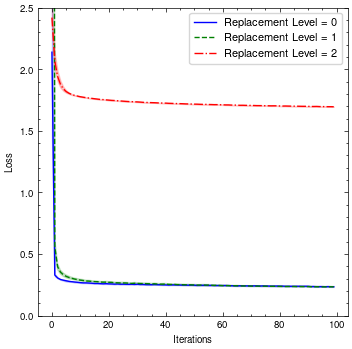

MNIST train_acc


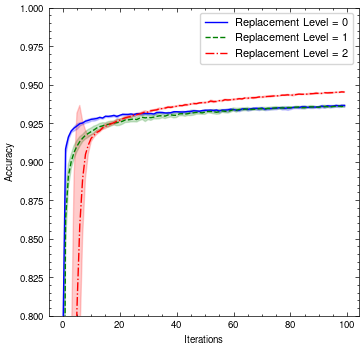

MNIST test_loss


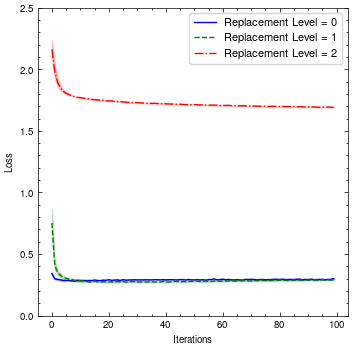

MNIST test_acc


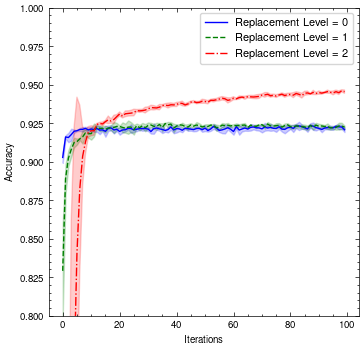

FashionMNIST train_loss


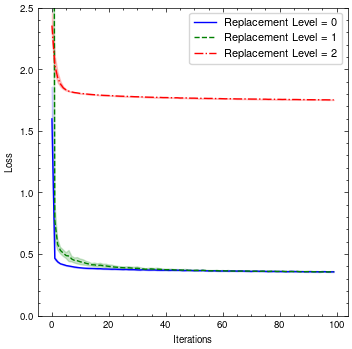

FashionMNIST train_acc


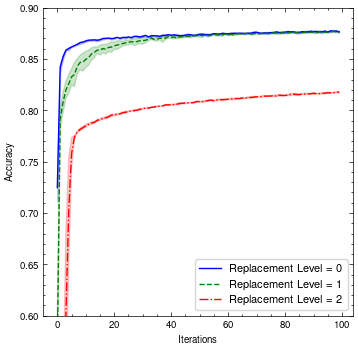

FashionMNIST test_loss


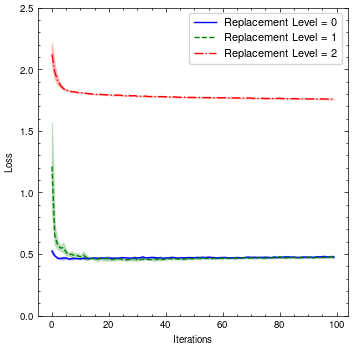

FashionMNIST test_acc


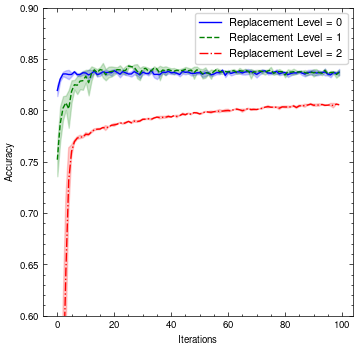

CIFAR10 train_loss


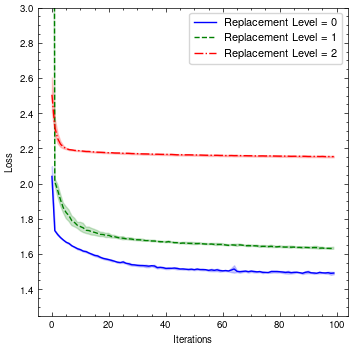

CIFAR10 train_acc


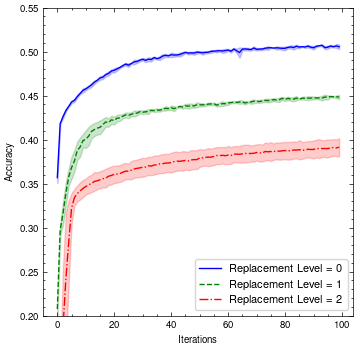

CIFAR10 test_loss


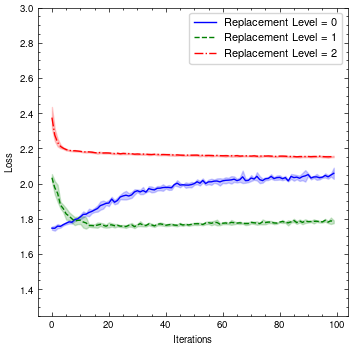

CIFAR10 test_acc


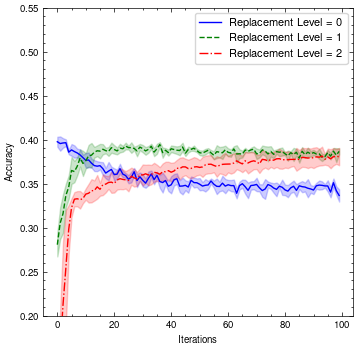

In [18]:
iters = np.arange(len(processed_avg['MNIST'][0]['train_loss']))
for dataset in datasets:
  for metric_name in metrics:
    print(dataset, metric_name)
    fig = plt.figure(figsize=(4, 4))
    plt.plot(iters, processed_avg[dataset][0][metric_name], label='Replacement Level = 0',color='blue', linestyle='-',)
    plt.plot(iters, processed_avg[dataset][1][metric_name], label='Replacement Level = 1',color='green', linestyle='--')
    plt.plot(iters, processed_avg[dataset][2][metric_name], label='Replacement Level = 2',color='red', linestyle='-.')
    # standard deviations
    plt.fill_between(iters, processed_avg[dataset][0][metric_name]-processed_std[dataset][0][metric_name], processed_avg[dataset][0][metric_name]+processed_std[dataset][0][metric_name], color='blue', alpha=0.2)
    plt.fill_between(iters, processed_avg[dataset][1][metric_name]-processed_std[dataset][1][metric_name], processed_avg[dataset][1][metric_name]+processed_std[dataset][1][metric_name], color='green', alpha=0.2)
    plt.fill_between(iters, processed_avg[dataset][2][metric_name]-processed_std[dataset][2][metric_name], processed_avg[dataset][2][metric_name]+processed_std[dataset][2][metric_name], color='red', alpha=0.2)
    #plt.title('MNIST Train Loss')
    if 'acc' in metric_name:
      if dataset == 'CIFAR10':
        plt.ylim(0.2, 0.55)
      elif dataset == 'FashionMNIST':
        plt.ylim(0.6, 0.9)
      else:
        plt.ylim(0.8, 1)
    else:
      if dataset == 'CIFAR10':
        plt.ylim(1.25, 3.0)
      else:
        plt.ylim(0, 2.5)
    plt.xlabel('Iterations')
    if 'acc' in metric_name:
      plt.ylabel('Accuracy')
    else:
      plt.ylabel('Loss')
    plt.legend(frameon=True, prop={'size': 8})
    plt.show()
    fig.savefig(os.path.join(res_folder, f"eqx_{dataset}_{metric_name}.pdf"))